# CSE 144 Spring 2022 Assignment 1

In this assignment, the goal is to build a linear regression model to predict the song popularity based on energy, acoustics, instumentalness, liveness, dancibility, etc. We'll be using the [Song Popularity Dataset](https://www.kaggle.com/datasets/yasserh/song-popularity-dataset) dataset from Kaggle dataset.

In the first section, you'll perform standard data preprocessing using techniques we covered in class. In the second section, you'll train a simple linear regression model.

You should be able to use NumPy, Pandas, and the `train_test_split()` function from scikit-learn to complete everything in this assignment. We also imported Matplotlib for you to visualize the training and validation loss.

Remember that tuning on the test loss is prohibited.

## Rubric

The assignment is worth 57 points in total:
- Data preprocessing (12 points)
    - drop missing values (2 points)
    - drop outliers (5 points)
    - normalization (5 points)
- Dataset split (10 points)
    - test set split (5 points)
    - k-fold train and validation set split (5 points)
- Linear regression (25 points)
    - MSE_loss (3 points)
    - Gradient (5 points)
    - Specify the epoch number and learning rate (0 points)
    - Theta initialization (3 points)
    - Translate dataframe to numpy (3 points)
    - Traininig (5 points)
        - Save train and val loss (2 points)
        - Update parameters (3 points)
    - Find best parameters (3 points)
    - Evaluate on test set (3 points)
    
- Report (10 points, in a separate PDF file)
- Bonus (3 points)
    - If your test loss is below 0.025

In [ ]:
!python --version

Python 3.7.13


In [ ]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange

import random
seed = 144
random.seed(seed)
np.random.seed(seed)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18835 entries, 0 to 18834
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18714 non-null  float64
 1   song_duration_ms  18717 non-null  float64
 2   acousticness      18717 non-null  float64
 3   danceability      18712 non-null  float64
 4   energy            18697 non-null  float64
 5   instrumentalness  18700 non-null  float64
 6   key               18721 non-null  float64
 7   liveness          18695 non-null  float64
 8   loudness          18716 non-null  float64
 9   audio_mode        18715 non-null  float64
 10  speechiness       18727 non-null  float64
 11  tempo             18715 non-null  float64
 12  audio_valence     18709 non-null  float64
dtypes: float64(13)
memory usage: 2.0 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03306dd410>,
      dtype=object)

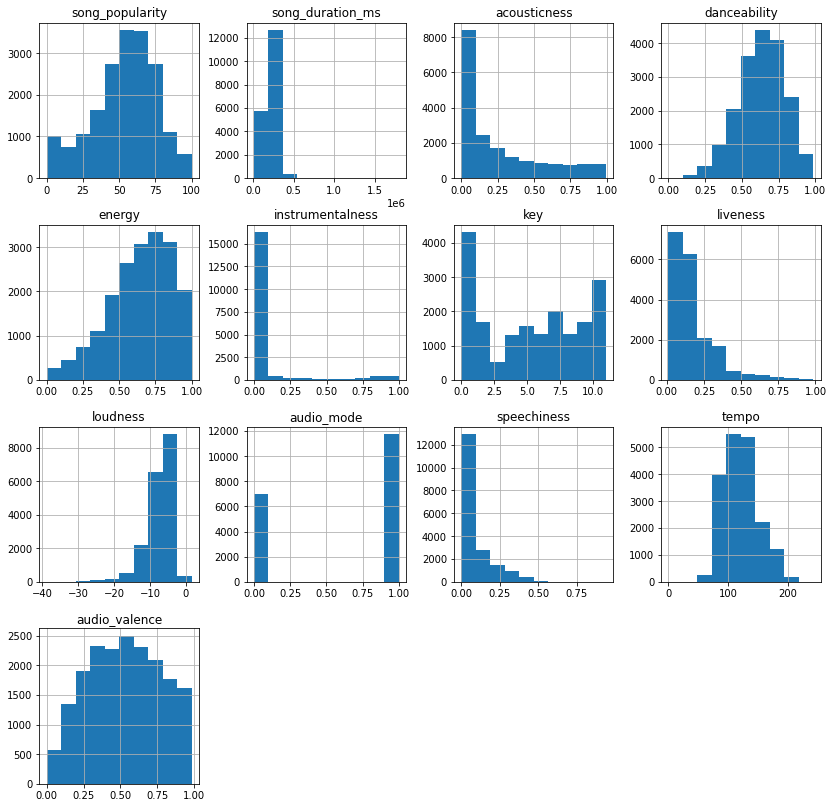

In [ ]:
# Load data
data = pd.read_csv("./song_data.csv", index_col=0).drop(["song_name"], axis = 1)
#print('max: ',data['tempo'].max())

# Visualize data 
data.info()
data.hist(figsize=(14,14))
#y = data["song_popularity"]
#print("y.shape: ", y.shape)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Data Cleaning
`data.info()` shows that there are some missing values in the dataset. Also, we can see from the histogram that outliers exist for some features. Moreover, the range of different features has a huge gap: most in (0,1), but some are on the order of 1e2, or even 1e5. In the following you need to perform:
1. Drop rows that contain NULL values.
2. Remove outliers for features in ['song_duration_ms', 'instrumentalness'] based on interquantile range.
3. Scale ranges of independent variables using Z-score method, and normalize the range of dependent feature ['song_popularity'] from [0,100] to [0,1]

In [ ]:
# drop rows that have NULL value
# ========== YOUR CODE STARTS HERE ==========
print(data['song_duration_ms'])
data=data.dropna(how="any")
# ========== YOUR CODE ENDS HERE ============

'''
Remove outliers for features in ['song_duration_ms', 'instrumentalness'] 
based on interquantile range. Here for each feature, we first sort data in an ascending order.
Let q1 and q3 be the data that ranks 25% and 75% respectively. We then let iqr = q3 - q1, and 
compute 
                a = q1 - iqr x 1.5,
                b = q3 + iqr x 1.5,
and remove the data out of the range [a, b].
Note: this can be realized with function quantile().
'''
# print(data['song_duration_ms'])
for feature in ['song_duration_ms', 'instrumentalness']:
    # ========== YOUR CODE STARTS HERE ==========
    q1 = np.quantile(data[feature],0.25)
    q3 = np.quantile(data[feature],0.75)
    
    #q1 = data[feature].quantile(0.25)
    #q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    a = q1 - iqr * 1.5
    b = q3 + iqr * 1.5
    #print(feature,"interval",a,b)
    # print("a: ",a)
    # print("b: ",b)
    # This line re adds NaNs
    #data.drop(data[feature] )
    #data[feature]
    temp = []
    for i,value in enumerate(data[feature]):
        if (a<=value and value<=b):
            temp.append(i)
    #data.drop(temp)
    #print(temp)
    data=data.iloc[temp]
            
    #type(data[feature])

    # ========== YOUR CODE ENDS HERE ============
data = data.reset_index(drop=True)
'''
Scale all independent fea
tures using z-score normalization, and normalize dependent feature range to [0, 1]
Note: use different mean and std for different columns!
'''
# ========== YOUR CODE STARTS HERE ==========
# y = data["song_popularity"]
# print("y.shape: ", y.shape)
for col in data.columns:
    if col != 'song_popularity':
        data[col] = (data[col] -data[col].mean())/data[col].std()
data["song_popularity"] = data["song_popularity"] / np.sqrt(np.sum(data["song_popularity"]**2))
# divide by 100 for dependent variable
# ========== YOUR CODE ENDS HERE ============
# 0 to 1
#data.shape

#data["song_popularity"]

0        262333.0
1        216933.0
2        231733.0
3        216933.0
4        223826.0
           ...   
18830    159645.0
18831    205666.0
18832    182211.0
18833    352280.0
18834    193533.0
Name: song_duration_ms, Length: 18835, dtype: float64


Now we visualize the data again.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12932 entries, 0 to 12931
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   12932 non-null  float64
 1   song_duration_ms  12932 non-null  float64
 2   acousticness      12932 non-null  float64
 3   danceability      12932 non-null  float64
 4   energy            12932 non-null  float64
 5   instrumentalness  12932 non-null  float64
 6   key               12932 non-null  float64
 7   liveness          12932 non-null  float64
 8   loudness          12932 non-null  float64
 9   audio_mode        12932 non-null  float64
 10  speechiness       12932 non-null  float64
 11  tempo             12932 non-null  float64
 12  audio_valence     12932 non-null  float64
dtypes: float64(13)
memory usage: 1.3 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03306e7150>,
      dtype=object)

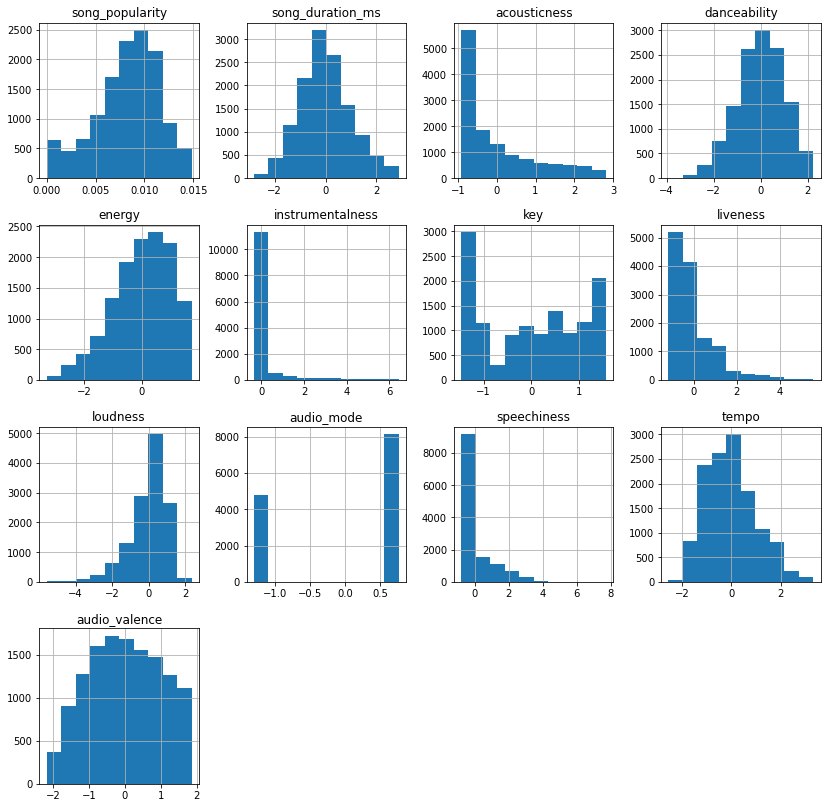

In [ ]:
data.info()
data.hist(figsize=(14,14))

## Dataset preparation
Next we will split dataset to train set, validation set and test set. First we randomly choose 30% as test set. Then we use $k$-fold validation on the remaining 70% to generate $k$ different train set and validation set pairs, where $k=5$.

In [ ]:
def test_split(data, test_size: float=0.3, seed=seed):
    '''
    Use function train_test_split() to split test set.
    '''
    # ========== YOUR CODE STARTS HERE ==========
    y = data["song_popularity"]
    # print("y.shape: ", y.shape)
    X = data[['song_duration_ms', 'acousticness', 'danceability',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness',
       'audio_mode', 'speechiness', 'tempo', 'audio_valence']]

    # print("X.shape: ", X.shape)
    # print("y.shape: ", y.shape)
    # print("data.shape: ", data.shape)

    X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size=test_size,random_state=seed)

    # ========== YOUR CODE ENDS HERE ============
    
    return (X_train_val.reset_index(drop=True),
            y_train_val.reset_index(drop=True),
            X_test.reset_index(drop=True),
            y_test.reset_index(drop=True))
    

def train_val_split(X_train_val, y_train_val, k=5, seed=seed):
    '''
    Use given index sets to generate k train and validation pairs. The return value should be 
    a list whose components are tuples:
    [(X_train1, y_train1, X_val1, y_val1), ..., (X_traink, y_traink, X_valk, y_valk)]
    
    Here suppose data length is 10, the index sets could be like:
                    [[2,5], [1,6], [3,8], [9,4], [0,7]]
                    
    '''
    # a list of 5 huge tuples
    index_shuffle = list(X_train_val.index)
    random.shuffle(index_shuffle)
    #print(index_shuffle)
    index_split_list = [[index_shuffle[i+j] for i in range(0, len(index_shuffle), 5)  if i+j<len(index_shuffle)] for j in range(5)]
    #print(index_split_list)
    train_val_pairs = [(None, None, None, None) for _ in range(k)]
    #print(train_val_pairs)
    # ========== YOUR CODE STARTS HERE ==========

    validation_set = []
    training_set = []

    for i in range(k):
        # print(i," as validation set")
        for j in range(k):
            if j == i:
                validation_set=index_split_list[i]
            else:
                training_set+=index_split_list[j]

        train_val_pairs_list = list(train_val_pairs[i])
        train_val_pairs_list[0] = X_train_val.iloc[training_set].copy()
        train_val_pairs_list[1] = y_train_val.iloc[training_set].copy()
        train_val_pairs_list[2] = X_train_val.iloc[validation_set].copy()
        train_val_pairs_list[3] = y_train_val.iloc[validation_set].copy()
        train_val_pairs[i] = tuple(train_val_pairs_list)
        
        training_set.clear()

    # ========== YOUR CODE ENDS HERE ============    
    return train_val_pairs

X_train_val, y_train_val, X_test, y_test = test_split(data)
train_val_pairs = train_val_split(X_train_val, y_train_val)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Final train loss for the best model: 0.040932369526666054
Final validation loss for the best model: 0.009698014038313316
Parameters for the best model:  [[ 8.15415969e-03]
 [ 9.75828473e-05]
 [-2.73585307e-04]
 [ 4.17149727e-04]
 [-4.18850241e-04]
 [-1.59165811e-04]
 [-9.56624562e-05]
 [-1.31669290e-04]
 [ 5.27557077e-04]
 [-2.62323233e-05]
 [-7.41940030e-05]
 [-1.25628899e-05]
 [-3.77278349e-04]]


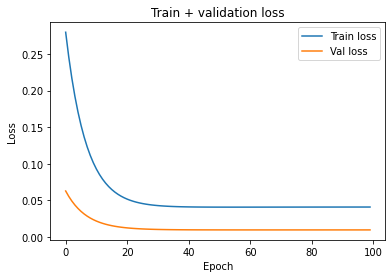

Test loss: 0.02267777557558609


In [ ]:
#from _typeshed import IdentityFunction
def MSE_loss(pred: np.ndarray, target: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    # sum = 0
    # length = len(target)
    # for i in range(length):
    #     sum += np.square(np.subtract(pred[i],target[i]))
    # return sum[0] / (2 * length)
    length = len(target)
    return np.sum(np.square(pred - target))/(2*length)
    # ========== YOUR CODE ENDS HERE ============ 

def gradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    # term1 = np.dot(theta.T,X.T)
    term1 = np.matmul(theta.T,X.T)
    term2 = term1 - y.T
    return np.dot(term2,X)
    # ========== YOUR CODE ENDS HERE ============ 

# Specify epoch and learning rate
# ========== YOUR CODE STARTS HERE ==========
min = float('inf')
num_epochs = 100
learning_rate = 0.00001
# ========== YOUR CODE ENDS HERE ============ 
k = 5
train_loss_history = [[] for _ in range(k)]
val_loss_history = [[] for _ in range(k)]

theta_min = None
index_min = None
loss_min = None

for i in range(k):
    X_train, y_train, X_val, y_val = train_val_pairs[i]
    
    # Translate dataframe to numpy     
    # ========== YOUR CODE STARTS HERE ==========
    np_X_train = X_train.to_numpy()
    np_y_train = y_train.to_numpy()
    np_X_val = X_val.to_numpy()
    np_y_val = y_val.to_numpy()
    np_X_train = np.c_[np.ones(len(np_X_train)), np_X_train]
    np_X_val = np.c_[np.ones(len(np_X_val)), np_X_val]
    # ========== YOUR CODE ENDS HERE ============
    
    # Initialize theta    
    # ========== YOUR CODE STARTS HERE ==========
    theta = np.zeros(shape=(13,1))
    # ========== YOUR CODE ENDS HERE ============
    for epoch in trange(num_epochs, desc="Epoch"):
        # Compute loss, and save to train_loss_history and val_loss_history
        # ========== YOUR CODE STARTS HERE ==========
        # print("np_X_train.shape: ",np_X_train.shape)
        # print("theta.shape: ",theta.shape)
        hypothesis = np.matmul(np_X_train,theta)
        loss = MSE_loss(hypothesis,np_y_train)
        train_loss_history[i].append(loss)
        # ========== YOUR CODE ENDS HERE ============
        # Update parameter
        # ========== YOUR CODE STARTS HERE ==========
        x = gradient(np_X_train,np_y_train,theta)
        x*=learning_rate
        theta -= x.T
        # ========== YOUR CODE ENDS HERE ============
    # Inference on validation set, and find the best parameters. Save corresponding parameters and index in theta_min and  index_min
    # ========== YOUR CODE STARTS HERE ==========
        val_hypothesis = np.matmul(np_X_val,theta)
        val_loss = MSE_loss(val_hypothesis,np_y_val)
        val_loss_history[i].append(val_loss)
        if(val_loss<min):
            index_min = i
            theta_min=theta
            min=val_loss

        # if(index_min==None):
        #     theta_min=theta
        #     index_min=epoch 
        # elif(val_loss < val_loss_history[i][-1]):
        #     theta_min = theta
        #     index_min = epoch

    # ========== YOUR CODE ENDS HERE ============

print(f"Final train loss for the best model: {train_loss_history[index_min][-1]}")
print(f"Final validation loss for the best model: {val_loss_history[index_min][-1]}")
print("Parameters for the best model: ",theta_min)

plt.plot(np.arange(num_epochs), train_loss_history[index_min], label="Train loss")
plt.plot(np.arange(num_epochs), val_loss_history[index_min], label="Val loss")
plt.title("Train + validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Evaluate on test set
# ========== YOUR CODE STARTS HERE ==========
np_X_test = X_test.to_numpy()
np_y_test = y_test.to_numpy()
np_X_test = np.c_[np.ones(len(np_X_test)), np_X_test]
test_hypothesis = np.matmul(np_X_test,theta_min)
test_loss = MSE_loss(test_hypothesis,np_y_test)
# ========== YOUR CODE ENDS HERE ============                  
print(f"Test loss: {test_loss}")